In [1]:
import csv
import nltk
import re
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import csv
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Embedding, GRU, SimpleRNN, RNN, LSTM, Flatten, Activation
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support
# from baseline import bong
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import time
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
with open('dev_en.tsv') as file1, \
     open('test_en.tsv') as file2, \
     open('train_en.tsv') as file3:
     val_df = pd.read_csv(file1, sep='\t+')
     test_df = pd.read_csv(file2, sep='\t+', header=None)
     train_df = pd.read_csv(file3, sep='\t+')

test_df.columns = ['id', 'text','HS', 'TR','AG']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
print( val_df.shape)
print( test_df.shape)
print(train_df.shape)

(1000, 5)
(2971, 5)
(9000, 5)


In [4]:
#quick description of the dataset attributes, and looking for non-null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9000 non-null   int64 
 1   text    9000 non-null   object
 2   HS      9000 non-null   int64 
 3   TR      9000 non-null   int64 
 4   AG      9000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 351.7+ KB


In [5]:
#checking missing values 
val_df.isnull().sum()
test_df.isnull().sum()
train_df.isnull().sum()

id      0
text    0
HS      0
TR      0
AG      0
dtype: int64

In [6]:
val_df.head()

,id,text,HS,TR,AG
0,18201,I swear I’m getting to places just in the nick...,0,0,0
1,18202,I’m an immigrant — and Trump is right on immig...,0,0,0
2,18203,#IllegalImmigrants #IllegalAliens #ElectoralSy...,1,0,1
3,18204,@DRUDGE_REPORT We have our own invasion issues...,1,0,1
4,18205,Worker Charged With Sexually Molesting Eight C...,0,0,0


In [7]:
test_df.head()

,id,text,HS,TR,AG
0,31568,"Bro is a bitch, fucking cunt https://t.co/dQ8J...",0,0,0
1,30734,I'm rewatching Breaking Bad & I could see why ...,1,1,0
2,31227,@charliekirk11 @asia742 364 down only about 12...,0,0,0
3,31224,>Harasses women and calls them bitch and crabb...,0,0,0
4,31139,"Bitch you ain't gotta call my phone, matter fa...",0,0,0


In [8]:
train_df[train_df.duplicated()] #No duplicates found. 

,id,text,HS,TR,AG


In [9]:
type(test_df)

pandas.core.frame.DataFrame

In [10]:
print("Number of tweets classified as Hate Speech in Dev dataset: ", len(val_df[val_df['HS'] == 1]))
print("Number of tweets classified as Hate Speech in Test dataset: ", len(test_df[test_df['HS'] == 1]))
print("Number of tweets classified as Hate Speech in Train dataset: ", len(train_df[train_df['HS'] == 1]))

Number of tweets classified as Hate Speech in Dev dataset:  427
Number of tweets classified as Hate Speech in Test dataset:  1252
Number of tweets classified as Hate Speech in Train dataset:  3783


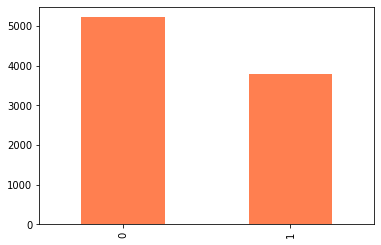

In [11]:
train_df['HS'].value_counts().plot.bar(color = 'coral', figsize = (6, 4))

In [12]:
train_df.groupby('HS').describe()

id                                                                   \
     count         mean          std    min     25%     50%     75%     max   
HS                                                                            
0   5217.0  4981.122676  2835.620564  204.0  2393.0  4543.0  7647.0  9200.0   
1   3783.0  4313.503304  2171.401921  201.0  2517.0  4806.0  5761.5  9198.0   

        TR            ...                AG                                \
     count      mean  ...  75%  max   count      mean       std  min  25%   
HS                    ...                                                   
0   5217.0  0.000000  ...  0.0  0.0  5217.0  0.000000  0.000000  0.0  0.0   
1   3783.0  0.354481  ...  1.0  1.0  3783.0  0.412107  0.492279  0.0  0.0   

                   
    50%  75%  max  
HS                 
0   0.0  0.0  0.0  
1   0.0  1.0  1.0  

[2 rows x 24 columns]

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

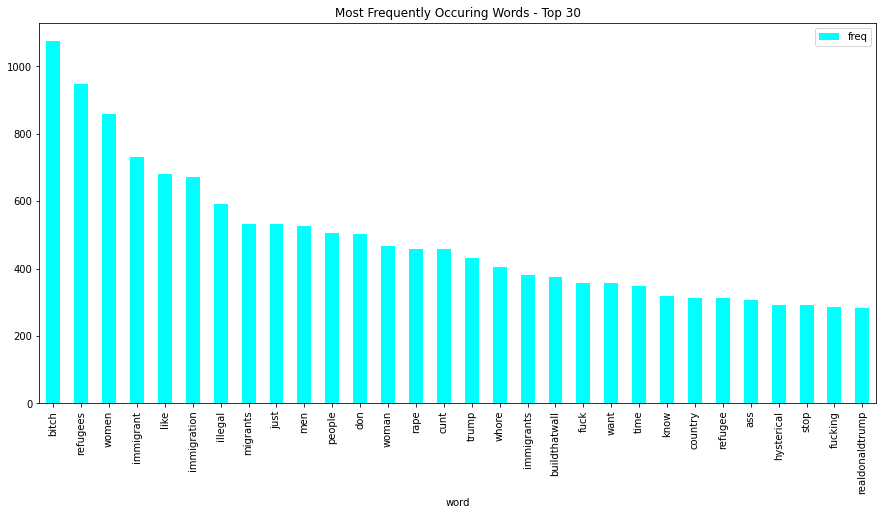

In [13]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.drop([0, 20], axis=0, inplace=True) # First "Word" is 'https', 21st word is 'amp', removing them

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'cyan')
plt.title("Most Frequently Occuring Words - Top 30")

In [14]:
# adding a column to represent the length of the tweet

train_df['len'] =train_df['text'].str.len()
train_df.head(10)

,id,text,HS,TR,AG,len
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0,121
1,202,Why would young fighting age men be the vast m...,1,0,0,300
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0,255
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0,126
4,205,Orban in Brussels: European leaders are ignori...,0,0,0,122
5,206,@KurtSchlichter LEGAL is. Not illegal. #BuildT...,1,0,0,53
6,207,@RitaPanahi @826Maureen @RealCandaceO Antifa a...,0,0,0,212
7,208,Ex-Teacher Pleads Not guilty To Rape Charges h...,0,0,0,68
8,209,still places on our Bengali (Sylheti) class! i...,0,0,0,159
9,210,DFID Africa Regional Profile: July 2018 https:...,0,0,0,63


In [15]:
print(train_df[['len']].describe())

               len
count  9000.000000
mean    140.013111
std      70.379132
min      10.000000
25%      87.000000
50%     129.000000
75%     176.000000
max     327.000000


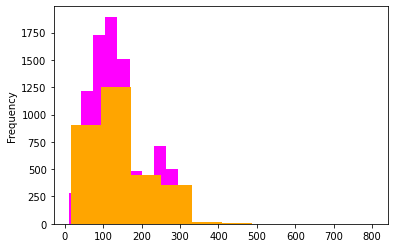

In [16]:
length_train = train_df['text'].str.len().plot.hist(color = 'magenta', figsize = (6, 4))
length_test = test_df['text'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [17]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [18]:
# extracting hashtags from non racist/misogynistic tweets
HT_regular = hashtag_extract(train_df['text'][train_df['HS'] == 0])

# extracting hashtags from racist/misogynistic tweets
HT_negative = hashtag_extract(train_df['text'][train_df['HS'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

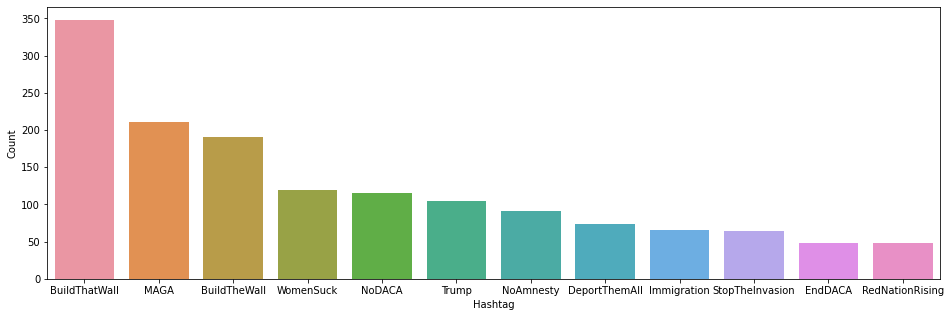

In [19]:
import seaborn as sns
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 12 most frequent hashtags     
d = d.nlargest(columns="Count", n = 12) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [20]:
print("Number of tweets with links in the train dataset: ", len(train_df[train_df.text.str.contains('https://[.\S]+', regex=True)])) # Number of tweets that contain a link
print("Number of tweets with links in the test dataset: ", len(test_df[test_df.text.str.contains('https://[.\S]+', regex=True)]))
print("Number of tweets with links in the dev dataset: ", len(val_df[val_df.text.str.contains('https://[.\S]+', regex=True)]))

Number of tweets with links in the train dataset:  4224
Number of tweets with links in the test dataset:  267
Number of tweets with links in the dev dataset:  364


# **SVM Implementation**

In [21]:
def preprocess_svm(df):
  df1 = df.copy()
  df1['text'] = df1.text.str.lower()
  df1['text'] = df1.text.str.replace('&amp|&', ' and ', regex=True)
  df1['text'] = df1.text.str.replace('@[\w\d]+|http[s]*://[.\S]+', '', regex=True)
  df1['text'] = df1.text.str.replace('[#,.:;\"]', ' ', regex=True)
  df1['text'] = df1.text.str.replace('[^#a-zA-Z\s\d]', '', regex=True)
  # df1['text'] = df1.text.str.replace('[#]', ' ', regex=True)
  df1['text'] = df1.text.str.replace('[\d]+', ' 0 ', regex=True)

  pos_tagged = df1.text.apply(lambda x: pos_tag(word_tokenize(x))).to_list()

  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV

  preprocessed_tweets = []
  for tweet in pos_tagged:
    lemmatized = WordNetLemmatizer()
    final_words = [lemmatized.lemmatize(word, tag_map[tag[0]]) for word, tag in tweet if (not word.isdigit()) and (word not in stopwords.words('english'))]
    preprocessed_tweets.append(" ".join(final_words))
  df1['preprocessed'] = preprocessed_tweets

  # model = CountVectorizer(min_df=2) # Removing words that appear less than 2 times
  # matrix = model.fit_transform(df1.preprocessed).toarray()
  # df_output = pd.DataFrame(data = matrix, columns = model.get_feature_names_out())
  return df1
# preprocess(train_df)

In [22]:
import nltk
nltk.download('punkt')
preprocessed_train = preprocess_svm(train_df)
preprocessed_val = preprocess_svm(val_df)
preprocessed_test = preprocess_svm(test_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
cv = CountVectorizer(min_df=2) # Removing words that appear less than 2 times
X_train = cv.fit_transform(preprocessed_train.preprocessed).toarray()
y_train = train_df.HS

X_test = cv.transform(preprocessed_test.preprocessed).toarray()
y_test = test_df.HS

In [24]:
cv = CountVectorizer(min_df=2) # Removing words that appear less than 2 times
X_train = cv.fit_transform(preprocessed_train.preprocessed).toarray()
y_train = preprocessed_train.HS

X_test = cv.transform(preprocessed_test.preprocessed).toarray()
y_test = preprocessed_test.HS

In [25]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [26]:
clf = SVC(C=1.0, kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
svm_mat = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print('\n', classification_report(y_test, y_pred))

0.6418714237630427

               precision    recall  f1-score   support

           0       0.66      0.78      0.72      1719
           1       0.60      0.45      0.52      1252

    accuracy                           0.64      2971
   macro avg       0.63      0.62      0.62      2971
weighted avg       0.64      0.64      0.63      2971



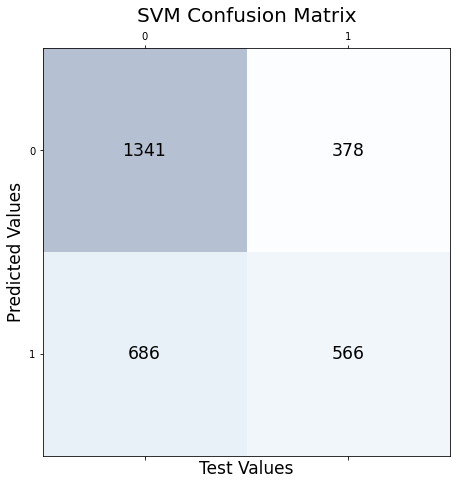

In [27]:
svm_mat
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(svm_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(svm_mat.shape[0]):
    for j in range(svm_mat.shape[1]):
        ax.text(x=j, y=i, s=svm_mat[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Test Values', fontsize=17)
plt.ylabel('Predicted Values', fontsize=17)
plt.title('SVM Confusion Matrix', fontsize=20)
#plt.savefig('SVM_Matrix')
plt.show()

# **LSTM Implementation**

In [28]:
!pip install fasttext

In [29]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [30]:
!pip install emot
import regex as re
import pickle
import string
import spacy
from nltk.tokenize import word_tokenize
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For emoticons

In [31]:
with open('slang.txt') as fin:
     rows = ( line.split('\t') for line in fin )
     slang_dict = { row[0]:row[1:] for row in rows }


keys_values = slang_dict.items()


slang_dict = {str(key): str(value).replace("\\xa0",' ').replace('\\n"]','').replace('["','').replace("['",'').replace("\\n']",'').replace("']",'') for key, value in keys_values}

In [33]:
load_model = spacy.load('en', disable = ['parser','ner']) # lemmatization using spacy

def preprocess(tweet):
    
    for slang in slang_dict: # slang conversion to classical english
      string=' '+slang+' '
      tweet = tweet.replace(string, ' '+slang_dict[slang]+' ')    
    tweet = re.sub('&amp|&', 'and', tweet) # replace & by and
    tweet = re.sub('@\w+', 'mention', tweet) #replace any mention with mention
    tweet = re.sub(' \d+ ', ' Digits ', tweet) # replace digits
    tweet = re.sub('\d+','', tweet)
    # hashtaglist = re.findall('#\w+',tweet)
    # for hashtag in hashtaglist:
        # tweet = re.sub(hashtag, ws.segment([hashtag])[0], tweet) # replace hashtags with segmented words
   

    for emot in UNICODE_EMOJI: # emoji conversion to text
        tweet = tweet.replace(emot, ' '.join(UNICODE_EMOJI[emot].replace(',',' ').replace('_',' ').replace(':','').split()))   
    for emot in EMOTICONS_EMO:
        tweet = tweet.replace(emot, ' '.join(EMOTICONS_EMO[emot].replace('_',' ').replace(',','').split()))
    for slang in slang_dict: # slang conversion to classical english
      string1=' '+slang+' '
      tweet = tweet.replace(string1, ' '+slang_dict[slang]+' ')
    import string
    for character in string.punctuation:
      tweet = tweet.replace(character, '') #remove punctuation
    # load_model = spacy.load('en', disable = ['parser','ner']) # lemmatization using spacy
    doc = load_model(tweet) # 
    tweet=" ".join([token.lemma_ for token in doc])
    tweet_tokenized = word_tokenize(tweet)
    tweet = [w for w in tweet_tokenized if not w.lower() in stopwords.words("english")] # removing stopwords
    return tweet

In [34]:
xtrain=train_df['text'].apply(preprocess)
ytrain=train_df['HS']
xtest = test_df['text'].apply(preprocess)
ytest = test_df['HS']
xval = val_df['text'].apply(preprocess)
yval = val_df['HS']

In [35]:
xtrain_sents = xtrain.apply(lambda x:" ".join(x))
xtest_sents = xtest.apply(lambda x:" ".join(x))
xval_sents = xval.apply(lambda x:" ".join(x))


In [36]:
tok = Tokenizer()
tok.fit_on_texts(xtrain_sents)
word_seq_train = tok.texts_to_sequences(xtrain_sents)
word_seq_test = tok.texts_to_sequences(xtest_sents)
word_seq_val = tok.texts_to_sequences(xval_sents)

word_index = tok.word_index

word_seq_train = pad_sequences(word_seq_train, maxlen = 60)
word_seq_test = pad_sequences(word_seq_test, maxlen = 60)
word_seq_val = pad_sequences(word_seq_val, maxlen = 60)


In [37]:
ft_dict = {}
for tweet in xtrain:
  for word in tweet:
    if word not in ft_dict:
      ft_dict[word] = ft.get_word_vector(word)

In [38]:
words_not_found = []
nb_words = len(word_index)+1
embed_dim=300
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = ft_dict.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 6440


In [39]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim, input_length=60, weights=[embedding_matrix], trainable=False))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           6193500   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,236,157
Trainable params: 42,657
Non-trainable params: 6,193,500
_________________________________________________________________


In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history = model.fit(word_seq_train, ytrain, batch_size=128, epochs=30, validation_data=(word_seq_test, ytest), shuffle=False)

Epoch 1/30
71/71 [==============================] - 9s 94ms/step - loss: 0.7404 - accuracy: 0.5269 - val_loss: 0.6952 - val_accuracy: 0.5099
Epoch 2/30
71/71 [==============================] - 6s 84ms/step - loss: 0.6527 - accuracy: 0.6017 - val_loss: 0.6959 - val_accuracy: 0.5086
Epoch 3/30
71/71 [==============================] - 6s 85ms/step - loss: 0.6359 - accuracy: 0.6372 - val_loss: 0.6990 - val_accuracy: 0.5039
Epoch 4/30
71/71 [==============================] - 6s 85ms/step - loss: 0.6316 - accuracy: 0.6472 - val_loss: 0.7021 - val_accuracy: 0.5022
Epoch 5/30
71/71 [==============================] - 6s 85ms/step - loss: 0.6258 - accuracy: 0.6488 - val_loss: 0.7044 - val_accuracy: 0.4995
Epoch 6/30
71/71 [==============================] - 6s 86ms/step - loss: 0.6201 - accuracy: 0.6482 - val_loss: 0.7092 - val_accuracy: 0.4904
Epoch 7/30
71/71 [==============================] - 6s 85ms/step - loss: 0.5572 - accuracy: 0.7267 - val_loss: 0.8530 - val_accuracy: 0.4214
Epoch 8/30
71

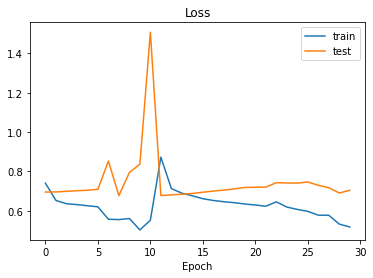

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

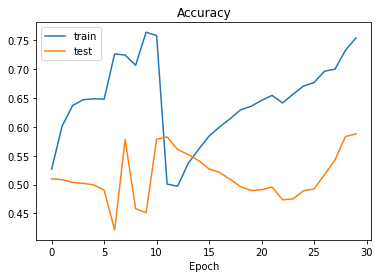

In [43]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [44]:
ypred = model.predict(word_seq_test)
ypred = ypred.round(0).astype('int')

In [45]:
print(classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1563
           1       0.57      0.51      0.54      1408

    accuracy                           0.59      2971
   macro avg       0.59      0.58      0.58      2971
weighted avg       0.59      0.59      0.59      2971



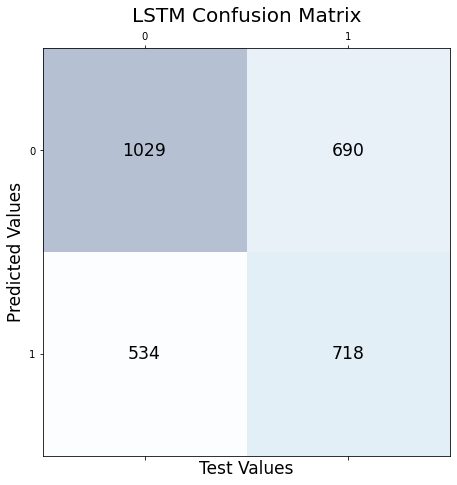

In [46]:
lstm_mat = confusion_matrix(ytest, ypred)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(lstm_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(lstm_mat.shape[0]):
    for j in range(lstm_mat.shape[1]):
        ax.text(x=j, y=i, s=lstm_mat[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Test Values', fontsize=17)
plt.ylabel('Predicted Values', fontsize=17)
plt.title('LSTM Confusion Matrix', fontsize=20)
#plt.savefig('SVM_Matrix')
plt.show()